# Outline

**[Introduction](#introduction)**
- Research Question
- Project goal

**[Data Preprocessing](#data-preprocessing)**
- [Cleaning data](#cleaning-the-data): [Handling mistakes](#handling-mistakes), [outliers](#outliers)
- [Visualization](#visualization)
- [Encoding](#encoding), [splitting data and standardization](#splitting-data-and-standardization)

**[Model Building](#model-building)**
- [Logistic Regression](#logistic-regression) model + evaluation
- Decision Tree

**Performance**
- Confusion Matrix
- Accuracy, F1-Score, ROC-AUC

**Conclusion**
- Which model performs better
- Reflection

**[References](#references)**

# Introduction
The purpose of this project is to build and evaluate machine learning models that classify fruits (apples, bananas, grapes) based on their features such as color, size and weight.  
This task reflects a typical supervised classification problem: the model is trained on labeled data and then evaluated on its ability to classify new data.
The goals of this project are:
- To train and compare two classification models, Logistic Regression and Decision Tree.
- To showcase a transparent and structured workflow, including methodology.


In [258]:
# import basic libraries
import pandas as pd 
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Data Preprocessing
## Cleaning the data
At first, we read the data from the excel file and take a look at its structure. The dataset contains two columns specifying indeces, the duplicate needs to be removed, as it is redundant information and has no predictive value for machine learning. After that, a check for null values is performed, to ensure a complete dataset. This dataset contains none, so no action is necessary.

In [207]:
# Read data from excel file and save as dataframe
df = pd.read_excel('../data/fruit_data.xlsx')
df.head()


,Unnamed: 0,fruit_type,color,size,weight
0,0,grape,Yellow,Tiny,8.303385
1,1,apple,Pink,Largee,80.976370
2,2,banana,Pale Yellow,Large,74.615192
3,3,grape,Red,Tiny,6.924070
4,4,banana,Creamy White,Largee,82.002542


In [208]:
# Drop unnamed column, as indeces are already saved in dataframe
df.drop(columns=['Unnamed: 0'], inplace=True)
# Check for null values (can also be seen in df.info())
df.isnull().sum()

fruit_type    0
color         0
size          0
weight        0
dtype: int64

Now there are four columns left, fruit_type (the value to be predicted later), color and size, both as String objects and weight as a floating point number. It is assumed that the unit for weight is grams, as this would be most plausible for the given weights and fruits. Ounces and kilograms would be too heavy and milligrams too light.

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fruit_type  200 non-null    object 
 1   color       200 non-null    object 
 2   size        200 non-null    object 
 3   weight      200 non-null    float64
dtypes: float64(1), object(3)
memory usage: 6.4+ KB


The fruit types are balanced, that means that the model will not be biased towards one of the fruit types and no countermeasures like oversampling or undersampling are necessary.

In [210]:
# Check distribution of fruit types
df['fruit_type'].value_counts()

fruit_type
apple     70
grape     66
banana    64
Name: count, dtype: int64

### Handling Mistakes
In this case the dataset is relatively small and mistakes can be spotted by examining the data. To speed up this process, the unique values for each column were reviewed to find potential duplicates or inconsistencies. In a dataset that has too many different values for each column, e.g. demographic data for an entire city, a different approach is required. Like identifying low frequency values, strings with numbers in text fields or applying fuzzy string matching using libraries such as fuzzywuzzy.

In [211]:
# Look at possible fruit colors to find mistakes
unique_colors = df['color'].unique()
print(unique_colors)
# The dataset contains both 'Yellow' and 'Yellow1', therefore we replace the typo with the correct value
df['color'] = df['color'].replace({'Yellow1':'Yellow'})

['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Yellow1'
 'Purple' 'Black']


In [212]:
# Look at possible fruit sizes to find mistakes
unique_sizes = df['size'].unique()
print(unique_sizes)
# The dataset contains 'Large' and the typo 'Largee' which needs to be replaced
df['size'] = df['size'].replace({'Largee':'Large'})

['Tiny' 'Largee' 'Large' 'Small' 'Medium']


In [213]:
# Look at possible fruit types to find mistakes
unique_fruit = df['fruit_type'].unique()
print(unique_fruit)
# Labels do not contain typos

['grape' 'apple' 'banana']


### Outliers
In order to identify outliers, a general overview over the data is needed. It becomes apparent that the minimum weight is 1.0 and the maximum is 250.0. At first this may seem suspicious, but considering that the possible fruits range from very light fruits like grape to heavier fruits like bananas, the outliers cannot be determined by the overall weight distribution alone. Consequently, the data of the different fruit types has to be examined separately.

In [214]:
# General overview
df.describe()

,weight
count,200.000000
mean,59.047220
std,46.697739
min,1.000000
25%,8.142752
50%,63.109415
75%,94.367815
max,250.000000


Examining the statistics separated by fruit type, a few unusual values can already be spotted, as the minimum weight for an apple is roughly 8.3g and for a banana 27.7g. To further confirm the suspicion, boxplots of the weight distributions are helpful. Using seaborn, all three boxplots are visible without much configuration.

In [215]:
# Overview separated by fruit type
df.groupby("fruit_type")["weight"].describe()


,count,mean,std,min,25%,50%,75%,max
fruit_type,,,,,,,,
apple,70.0,93.720023,39.100208,8.300753,72.345856,92.585794,108.034470,250.000000
banana,64.0,74.908579,27.729121,26.524587,55.750320,77.121200,95.451442,116.380543
grape,66.0,6.892322,1.924690,1.000000,5.822353,6.461906,7.668747,10.902198


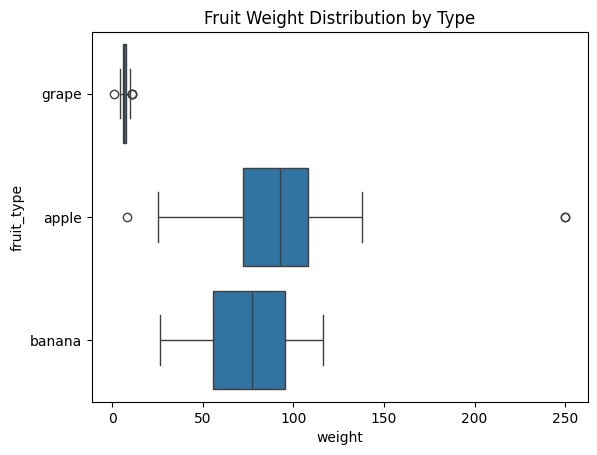

In [216]:
sns.boxplot(x="weight", y="fruit_type", data=df)
plt.title("Fruit Weight Distribution by Type")
plt.show()

In order to find the outliers, the Interquartile Range (IQR) method is used. For this, the difference between the weight at the first quartile (Q1) and at the third quartile (Q3) are calculated. The result multiplied by 1.5 is the limit for finding  outliers in both directions when added or subtracted to the first/third quartile. [1]   
As a result we get a dataframe only containing the possible outliers.

In [217]:
outliers = pd.DataFrame()

# iterate through the fruit types and create a subset for each
for fruit in df['fruit_type'].unique():
    subset = df[df['fruit_type'] == fruit]
    
    # 25th percentile
    Q1 = subset['weight'].quantile(0.25)
    # 75th percentile
    Q3 = subset['weight'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # values below or above 1.5 * Interquartile Range are outliers
    fruit_outliers = subset[
        (subset['weight'] < lower) | (subset['weight'] > upper)
    ]
    
    # If new outliers are found, add them to the dataframe
    outliers = pd.concat([outliers, fruit_outliers])

outliers

,fruit_type,color,size,weight
34,grape,Purple,Tiny,10.902198
37,grape,Yellow,Tiny,1.000000
138,grape,Green,Small,10.902198
192,grape,Green,Medium,10.902198
26,apple,Green,Small,250.000000
33,apple,Yellow,Medium,250.000000
175,apple,Green,Medium,8.300753


A few of the outliers (indices 37, 26, 33) have only zeroes after the decimal point. As this is quite unlikely and they are identified as outliers in the box plot, it is likely that they are measuring errors. A normal, medium sized apple (175) cannot weight 8.3g, making it probably a measuring fault. 
The three unusually heavy grapes (34, 138, 192) could also be measuring errors. Although theoretically, there could be a big grape weighing 10.9g, it is unlikely that there are 'small' and 'tiny' grapes this heavy.  
The medium sized grape weighing 10.9g may be unlikely, but as it is theoretically possible for a grape to weigh this much, there is no information on the type of grape etc. and the deviation is relatively small, it cannot be ruled out and will not be removed from the dataset.
The dataset contains other values that seem unlikely, like a banana weighing 27.7g, that are not identified as outliers using the IQR method, but as there is no other information about the fruit, e.g. if the fruits are fully grown, they will remain in the dataset.

In [218]:
# Index of the medium sized grape weighing 10.9g 
keep_index = [192]

# Get indices of all outliers except the one we want to keep
outliers_index = outliers.index.difference(keep_index)

# Remove the outliers from the dataframe
df_clean = df.drop(index=outliers_index)

Before continuing, the outliers and the cleaned data are saved as excel files, in case they need to be examined later and to make the different steps of data processing visible.

In [219]:
# Remove value that is kept in df_clean
outliers.drop(index=192, inplace=True)

# Save outliers as excel file
outliers.to_excel('../data/fruit_outliers.xlsx')

# Save cleaned fruit_data as excel file
df_clean.to_excel('../data/fruit_data_clean.xlsx')


## Visualization
Data visualization helps to get a better knowledge of how the different features correlate with each other.  
Size and weight should correlate with each other, but in this case, no matter what size the fruit is, the weight range is quite similar.  
Bananas range from roughly 25g to 120 grams no matter the size, small apples range from ~40g to 140g, whereas large apples range from ~25g to 135g. Grapes also maintain the same range across sizes.  
Although it is visible, that grapes are always tiny, small or medium and apples/bananas are always small, medium or large, the sizes of the fruits do not offer reliable insight into their weight, as they are overlapping a lot between sizes.

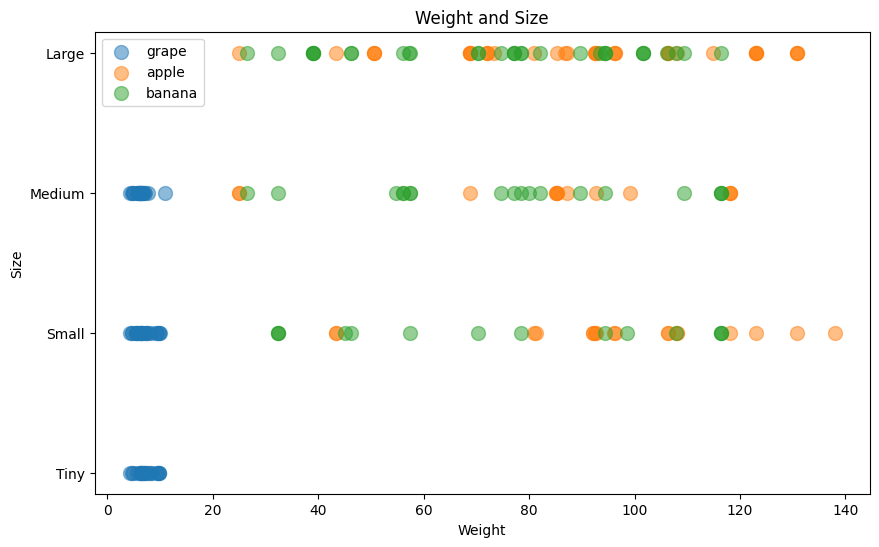

In [220]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each fruit type
for fruit in df_clean['fruit_type'].unique():
    subset = df_clean[df_clean['fruit_type'] == fruit]
    ax.scatter(subset['weight'], subset['size'], 
               label=fruit, s=100, alpha=0.5)

ax.set_title('Weight and Size')
ax.set_xlabel('Weight')
ax.set_ylabel('Size')
ax.legend()
plt.show()

The color distribution for the fruits reveals that some colors are only associated with a certain fruit, allowing reliable predictions by color. E.g. pink is only seen in apples, creamy white and pale yellow only in bananas and purple and black only in grapes.  
But the other colors (red, green, yellow) are quite evenly distributed between all fruit types, making it impossible to predict a fruit by its color alone.

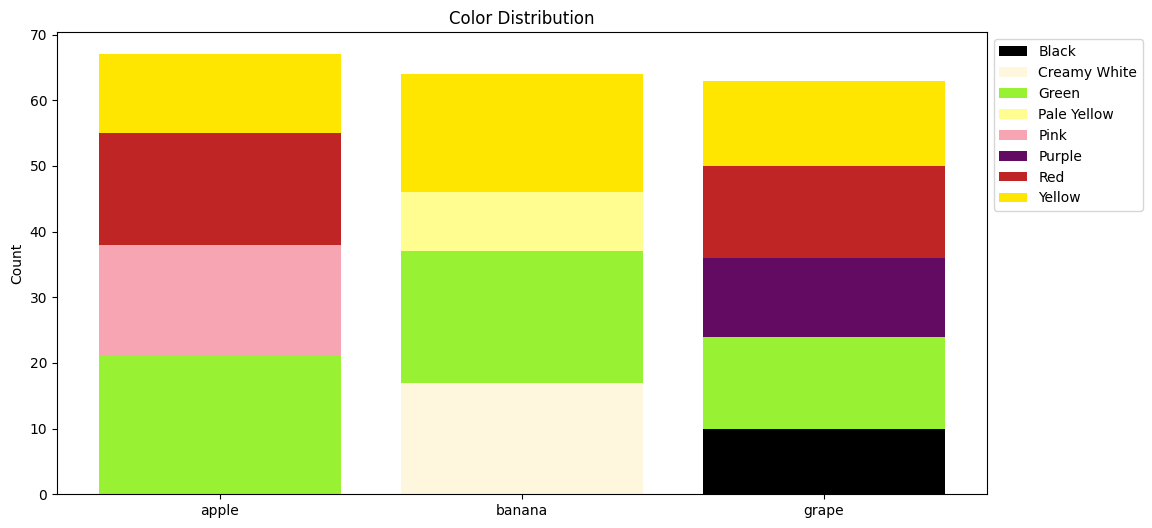

In [221]:
fig, ax = plt.subplots(figsize=(12, 6))

cross_tab = pd.crosstab(df_clean['fruit_type'], df_clean['color'])

# start with a list of zeros as long as the count of fruit_types, alternative [0,0,0]
bottom = np.zeros(len(cross_tab.index))
colors = [
    '#000000',   # black
    '#FFF7DD',   # creamy white
    "#99F134",   # green
    '#FFFD8F',   # pale yellow
    "#F7A5B3",   # pink
    "#630B63",   # purple
    "#C02525",   # red
    "#FFE600"    # yellow
]

for i, color_type in enumerate(cross_tab.columns):
    ax.bar(cross_tab.index, cross_tab[color_type], bottom=bottom, 
           label=color_type, color=colors[i % len(colors)])
    bottom += cross_tab[color_type]

ax.set_ylabel('Count')
ax.set_title('Color Distribution')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Encoding
As we need numerical data for logistic regression and we have two columns with categorical data, we need to encode them. Decision tree also works with categorical data, but because the two models will be compared later, it is best to use the same data for both to make the comparison accurate.  
First, 'color' needs to be encoded using One-Hot-Encoding, as there is no inherent order between colors. Mapping 'size' to numbers allows keeping the order the sizes have (small is bigger than tiny etc.).



In [222]:
df_encoded = df_clean[['fruit_type','weight']].copy()

# One-hot-encode the colors and add to df_encoded
color_encoded = pd.get_dummies(df_clean['color'], prefix='color', drop_first=True, dtype=int) # adding drop_first=True ro remove redundancy
df_encoded = pd.concat([df_encoded, color_encoded], axis=1)

# Map the sizes to numbers and add them to df_encoded
size_mapping = {'Tiny': 0, 'Small': 1, 'Medium': 2, 'Large': 3}
df_encoded['size_encoded'] = df_clean['size'].map(size_mapping)

df_encoded


,fruit_type,weight,color_Creamy White,color_Green,color_Pale Yellow,color_Pink,color_Purple,color_Red,color_Yellow,size_encoded
0,grape,8.303385,0,0,0,0,0,0,1,0
1,apple,80.976370,0,0,0,1,0,0,0,3
2,banana,74.615192,0,0,1,0,0,0,0,3
3,grape,6.924070,0,0,0,0,0,1,0,0
4,banana,82.002542,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
195,grape,9.774546,0,0,0,0,1,0,0,1
196,banana,39.012962,0,0,1,0,0,0,0,3
197,grape,7.409021,0,0,0,0,0,1,0,1
198,grape,4.651554,0,0,0,0,0,1,0,2


As all of our features are now numeric, it is possible to generate a heatmap, showing that weight and size are somewhat correlated, but as already seen in the plots above, they are not reliably connected. 

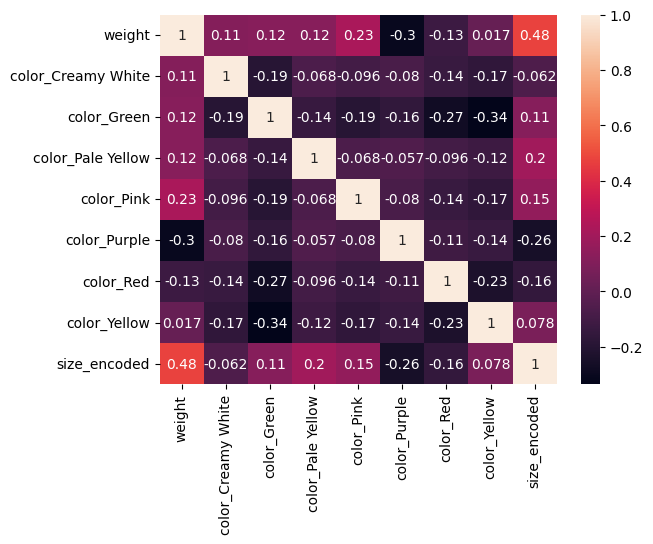

In [223]:
df_features = df_encoded.drop(columns='fruit_type')

sns.heatmap(df_features.corr(), annot = True);

## Splitting data and standardization
First, the target values (y) are separated from the predictors (X). Then the data is split into training and test data, in order to have some unseen data for the model to be evaluated on. [2]

In [224]:
# Predictors
X = df_features
# Target values
y = df_encoded['fruit_type']

# Splitting training and test data, random_state=1 so the split is reproducable,
# stratify=y to keep class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) 

For Logistic Regression the weight column will be scaled, because it contains continuous values with a larger scale than the other columns. This could disproportionately influence the model and prevent/slow convergence. The other columns do not need to be scaled because they are already on a small and consistent scale, as they have been encoded before. In order to test the performance of the scaled data, we will also train a model with unscaled data.   
The data is scaled using the Standard-Scaler, because the fixed range of the MinMax-Scaler is not needed and RobustScaler is not needed because outliers have already been removed.
As scaling is not necessary for Decision Tree because it makes splitting decisions based on feature value comparisons and thresholds rather than distance calculations or gradient descent, it is only trained with unscaled data.

In [225]:
# Scale training and test data
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[["weight"]] = scaler.fit_transform(X_train[["weight"]])
X_test_scaled[["weight"]] = scaler.transform(X_test[["weight"]])


# Model Building
## Logistic Regression

### Training the model and choosing hyperparameters

First, the model is trained with the scaled data, delivering an accuracy of 0.82. The training failed using the unscaled data as the model failed to converge, proving the assumption above right. Using cross validation, an accuracy of roughly 85.7 is reached on the model without modified hyperparameters. 

In [226]:
# Create model
model_scaled = LogisticRegression()

# Fit model to training data
model_scaled.fit(X_train_scaled, y_train)

model_scaled.score(X_test_scaled, y_test)

0.8205128205128205

In [227]:
# Create model
model = LogisticRegression()

# Fit model to training data
model.fit(X_train, y_train)

model.score(X_test, y_test)

c:\Coding-Projects\fruit-classifier\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8461538461538461

In [228]:
# Mean accuracy using cross validation
scores = cross_val_score(model_scaled, X_train_scaled, y_train, cv=10)
print(np.mean(scores))

0.8466666666666667


In order to see if the model can improve its performance, a few hyperparameter combinations will be tested using GridSearch. For this 'liblinear' as a solver was excluded, because it does not handle multi_class problems, well, consequently 'dual' is not included, as it only works with liblinear. The grid is split by penalties, because most solvers are only compatible with L2 penalty. [3]  
This reveals the parameters {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'} as the best, this will become the hyperparameters used for the Logistic Regression Model.

In [250]:
# Define parameter grid
param_grid = [
    # L1 penalty
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [2000, 3000],      # Higher iterations because max_iter was reached before convergence
        'class_weight': [None, 'balanced'],
    },
    # L2 penalty  
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga', 'lbfgs', 'newton-cg'],
        'max_iter': [1000, 2000, 3000],
        'class_weight': [None, 'balanced'],
    },

    # Elasticnet penalty
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [2000, 3000],       # Higher iterations because max_iter was reached before convergence
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Only used with elasticnet
        'class_weight': [None, 'balanced'],
    }
]

# Grid search
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.8580645161290322


### Evaluating the model
Testing the final model reveals that the accuracy is identical to the Linear Regression model with default parameters (default: 0.8205128205128205, final: 0.8205128205128205), but an improvement in the cross-validation-score is visible (default: 0.8466666666666667, final: 0.8529166666666667). This proves the tuned model to be slightly better, because the average performance across different validation sets is higher.

In [256]:
final_model = LogisticRegression(**grid_search.best_params_)
final_model.fit(X_train_scaled, y_train)

# Cross Validation
scores = cross_val_score(final_model, X_train_scaled, y_train, cv=10)
print(f"Cross-Validation-Score: {np.mean(scores)}")


# Final evaluation on untouched test set
final_score = final_model.score(X_test_scaled, y_test)
print(f"Final test accuracy: {final_score}")



Cross-Validation-Score: 0.8529166666666667
Final test accuracy: 0.8205128205128205


The classification report and confusion matrix reveal that the model is able to identify all grapes (recall 1.00) and predicts only two false positives (one apple and one banana). The precision is also the highest of them all, 87% of grape predictions are correct. For bananas, precision and recall are both 77%, three bananas were misclassified (two as apple and one as grape). Apple had higher precision than banana, but overall less apples were correctly recognized as apples, only 69% of all actual apples. Two of them were recognized as bananas and one as grape. A reason for this could be, that as seen in the [visualizations](#visualization), apples and bananas are in the same weight range, no matter the size and both can be green or yellow. As grapes generally weigh a lot less, the prediction was more accurate. The f1-scores show that the model performs similarly moderate on apples and bananas, whereas grapes are well classified (0.93).   
While the current model achieves 0.82% overall accuracy, the moderate f1-scores for apples and bananas show, that the model has problems distinguishing these fruits based on weight, color and size. Having additional features like 'shape' could improve the model, as there would be little to no overlap, different to the existing features.

In [ ]:
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       apple       0.82      0.69      0.75        13
      banana       0.77      0.77      0.77        13
       grape       0.87      1.00      0.93        13

    accuracy                           0.82        39
   macro avg       0.82      0.82      0.82        39
weighted avg       0.82      0.82      0.82        39

Confusion Matrix:
[[ 9  3  1]
 [ 2 10  1]
 [ 0  0 13]]


## Decision Tree
### Training the model and choosing hyperparameters

# References
[1] ‘Data Preprocessing in Python’, GeeksforGeeks, Oct. 29, 2017. Available: https://www.geeksforgeeks.org/machine-learning/data-preprocessing-machine-learning-python/. [Accessed: Oct. 11, 2025]  

[2] J. Britton, ‘Classification Basics: Walk-through with the Iris Data Set’, Towards Data Science, Jul. 27, 2020. Available: https://towardsdatascience.com/classification-basics-walk-through-with-the-iris-data-set-d46b0331bf82/. [Accessed: Oct. 11, 2025]  

[3] „LogisticRegression“, scikit-learn. Available: https://scikit-learn/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. [Accessed: Oct. 19, 2025]

